# Part1: the classic image classification task****

I start with image classification of normal chest xrays with that of covid19 chest xrays.

a pretrained modelfrom keras VGG16 has been used.

In [1]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=b67fe90335804e1ad341b5d130123b6ec7a27e68768669b7a646fc0ac7b5355e
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
        
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,InceptionV3
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense,Conv2D
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import pandas as pd
import shutil
import random
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist

# Any results you write to the current directory are saved as output.

**BUILD DATASET**

In [3]:
dataset_path = '../input/shenzhen'

In [4]:
samples = 25  

**BUILD NORMAL XRAY DATASET**

**PLOT THE XRAYs**

In [5]:
#helper functions to plot them in a grid
def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

In [6]:
normal_images = list(paths.list_images(f"{dataset_path}/normal"))
tb_images = list(paths.list_images(f"{dataset_path}/tb"))

**DATA PREPROCESSING**

Data Preprocessing involves
1. Resizing all the images
2. Extract the class from the filename, this helps us create labels for classification
3. Perform one hot encoding of all the labels
4. Split the data- 80% for training and 20% for testing. Train data will have 75 each for  images and labels. Test data will have 19 each for images and labels
5. we shall also do a little bit of data augmentation to generate more data from what we already have

In [7]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (299,299))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]

data = np.array(data) / 255.0




[INFO] loading images...


In [8]:
# perform one-hot encoding on the labels
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
lb = label_binarize(labels, classes=['normal','tb'])
#labels = lb.fit_transform(labels)
labels = to_categorical(lb)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, random_state=42)
# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

**DEFINING THE MODEL**

In [9]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 100
BS = 8

In [10]:
baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(299,299, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel=  Conv2D (padding="same", activation="relu", kernel_size=3, filters=32)(headModel)
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

2022-11-18 02:24:49.456787: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 02:24:49.557145: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 02:24:49.558031: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 02:24:49.559890: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


**TRAINING**

In [11]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
metrics=["accuracy"])


model.summary()

[INFO] compiling model...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None,

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(trainAug.flow(trainX, trainY, batch_size=BS),steps_per_epoch=len(trainX) // BS,validation_data=(testX, testY),validation_steps=len(testX) // BS,epochs=EPOCHS)

[INFO] training head...


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-11-18 02:24:53.585727: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-11-18 02:24:55.564619: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


66/66 [==============================] - 23s 216ms/step - loss: 0.6958 - accuracy: 0.5585 - val_loss: 0.6632 - val_accuracy: 0.8571
Epoch 2/100
66/66 [==============================] - 10s 145ms/step - loss: 0.6617 - accuracy: 0.6507
Epoch 3/100
66/66 [==============================] - 9s 143ms/step - loss: 0.6093 - accuracy: 0.7409
Epoch 4/100
66/66 [==============================] - 10s 152ms/step - loss: 0.5523 - accuracy: 0.7697
Epoch 5/100
66/66 [==============================] - 10s 149ms/step - loss: 0.5079 - accuracy: 0.7831
Epoch 6/100
66/66 [==============================] - 10s 150ms/step - loss: 0.4788 - accuracy: 0.7965
Epoch 7/100
66/66 [==============================] - 10s 156ms/step - loss: 0.4674 - accuracy: 0.8042
Epoch 8/100
66/66 [==============================] - 10s 148ms/step - loss: 0.4554 - accuracy: 0.8215
Epoch 9/100
66/66 [==============================] - 10s 154ms/step - loss: 0.4169 - accuracy: 0.8292
Epoch 10/100
66/66 [==============================] -

In [13]:
model.save('Xray_classification1.h5')

**PLOT TRAINING METRICS**

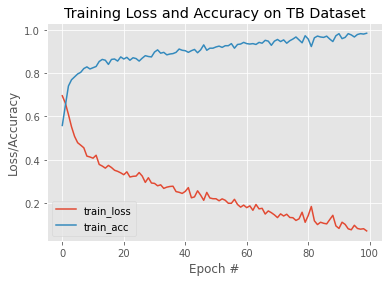

In [21]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
#plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
#plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on TB Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

<AxesSubplot:>

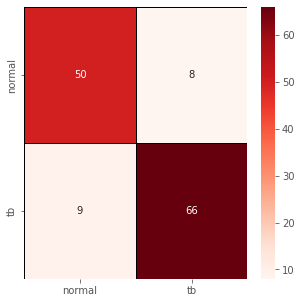

In [16]:
import seaborn as sns
Y_pred = model.predict(testX)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(testY, axis=1)
cm = confusion_matrix(Y_true, Y_pred)
disease_types=['normal','tb']
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Reds", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = disease_types , yticklabels = disease_types)

In [17]:
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [18]:
print(TPR)
print(TNR)
print(PPV)
print(NPV)
print(FPR)
print(FNR)
print(ACC)

0.88
0.8620689655172413
0.8918918918918919
0.847457627118644
0.13793103448275862
0.12
0.8721804511278195
